<h1>Capstone Project #2<h1> 
WEST NILE VIRUS

West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.



In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given <b style="color:red;">weather, location, testing, and spraying data</b>, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

# Importing the required libraries

In [414]:
# import libraries
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread
from sklearn import ensemble, preprocessing
%matplotlib inline
# Import baseline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn import svm, linear_model, datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Importing Datasets

In [4]:
Train=pd.read_csv('data/train.csv')
Test=pd.read_csv('data/test.csv')
Spray=pd.read_csv('data/spray.csv')
Weather=pd.read_csv('data/weather.csv')

# Data Wrangling

<h2>Spray dataset:<h2>

In [5]:
# Call the datasets and check the data and clean them
Spray.head(3)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157


In [6]:
#General info about Spray
Spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [7]:
Spray.isna().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [8]:
# Since we do not consider the time of the spray, let's get rif of that
Spray.drop('Time',axis=1,inplace=True)
Spray.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [9]:
# Date column is not Datetime object, so let's convert it to Datetime
def Dconverter(df):
    df["Date"]=pd.to_datetime(df['Date'])
    df["Year"]=df.Date.dt.year
    df["Month"]=df.Date.dt.month
    df["Day"]=df.Date.dt.day
    return df

In [10]:
Dconverter(Spray)
Spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Latitude   14835 non-null  float64       
 2   Longitude  14835 non-null  float64       
 3   Year       14835 non-null  int64         
 4   Month      14835 non-null  int64         
 5   Day        14835 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 695.5 KB


In [11]:
print(Spray.Year.unique())

[2011 2013]


<h2>Weather dataset<h2>

In [12]:
Weather.head(3)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [13]:
Weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [14]:
# Convert the Date column
Dconverter(Weather)
Weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Year', 'Month', 'Day'],
      dtype='object')

In [15]:
pd.DataFrame(Weather.isna().sum()).T

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Checking the missing values:
def miss_checker (df):
    missings={}
    for col in df.columns:
        num=[pd.Series(df[col]=='M').sum(),pd.Series(df[col]=='-').sum(),pd.Series(df[col]=='  T').sum()]
        missings[col]=num
    
    return missings
        #print("The missing value in column " + str(col)+ " is: " +"\n"+ str(num))

In [17]:
print(Weather.shape)
miss_checker(Weather)

(2944, 25)


{'Station': [0, 0, 0],
 'Date': [0, 0, 0],
 'Tmax': [0, 0, 0],
 'Tmin': [0, 0, 0],
 'Tavg': [11, 0, 0],
 'Depart': [1472, 0, 0],
 'DewPoint': [0, 0, 0],
 'WetBulb': [4, 0, 0],
 'Heat': [11, 0, 0],
 'Cool': [11, 0, 0],
 'Sunrise': [0, 1472, 0],
 'Sunset': [0, 1472, 0],
 'CodeSum': [0, 0, 0],
 'Depth': [1472, 0, 0],
 'Water1': [2944, 0, 0],
 'SnowFall': [1472, 0, 12],
 'PrecipTotal': [2, 0, 318],
 'StnPressure': [4, 0, 0],
 'SeaLevel': [9, 0, 0],
 'ResultSpeed': [0, 0, 0],
 'ResultDir': [0, 0, 0],
 'AvgSpeed': [3, 0, 0],
 'Year': [0, 0, 0],
 'Month': [0, 0, 0],
 'Day': [0, 0, 0]}

In [18]:
# The info come from two different weather station, which could be helpful to find missing values
Weather['Station'].value_counts()

1    1472
2    1472
Name: Station, dtype: int64

In [19]:
# First separate data from two different stations
Weather_s1=Weather[Weather['Station']==1]
Weather_s2=Weather[Weather['Station']==2]

In [20]:
# Merge the separated data
Weather_m=Weather_s1.merge(Weather_s2, on='Date',suffixes=('_s1', '_s2'))
Weather_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Station_s1      1472 non-null   int64         
 1   Date            1472 non-null   datetime64[ns]
 2   Tmax_s1         1472 non-null   int64         
 3   Tmin_s1         1472 non-null   int64         
 4   Tavg_s1         1472 non-null   object        
 5   Depart_s1       1472 non-null   object        
 6   DewPoint_s1     1472 non-null   int64         
 7   WetBulb_s1      1472 non-null   object        
 8   Heat_s1         1472 non-null   object        
 9   Cool_s1         1472 non-null   object        
 10  Sunrise_s1      1472 non-null   object        
 11  Sunset_s1       1472 non-null   object        
 12  CodeSum_s1      1472 non-null   object        
 13  Depth_s1        1472 non-null   object        
 14  Water1_s1       1472 non-null   object        
 15  Snow

In [21]:
print((Weather_m['Tavg_s1']=='M').sum())
print((Weather_m['Tavg_s2']=='M').sum())

0
11


In [22]:
# Replace the missing average temperature with mean of min and max temperature
for n,v in enumerate(Weather_m['Tavg_s2']):
    if v == 'M':
        Weather_m.loc[n,'Tavg_s2']=(Weather_m.loc[n,'Tmin_s2']+Weather_m.loc[n,'Tmax_s2'])/2
(Weather_m['Tavg_s2']=='M').sum()

0

In [23]:
# Checking the missing values of the merged weather data frame
miss_checker(Weather_m)
# Some columns miss the whole values:
miss_columns=['Water1_s1','Depart_s2','Sunrise_s2','Sunset_s2','Depth_s2','Water1_s2','SnowFall_s2']
Weather_m.drop(miss_columns,axis=1,inplace=True)
miss_checker(Weather_m)

{'Station_s1': [0, 0, 0],
 'Date': [0, 0, 0],
 'Tmax_s1': [0, 0, 0],
 'Tmin_s1': [0, 0, 0],
 'Tavg_s1': [0, 0, 0],
 'Depart_s1': [0, 0, 0],
 'DewPoint_s1': [0, 0, 0],
 'WetBulb_s1': [3, 0, 0],
 'Heat_s1': [0, 0, 0],
 'Cool_s1': [0, 0, 0],
 'Sunrise_s1': [0, 0, 0],
 'Sunset_s1': [0, 0, 0],
 'CodeSum_s1': [0, 0, 0],
 'Depth_s1': [0, 0, 0],
 'SnowFall_s1': [0, 0, 12],
 'PrecipTotal_s1': [0, 0, 163],
 'StnPressure_s1': [2, 0, 0],
 'SeaLevel_s1': [5, 0, 0],
 'ResultSpeed_s1': [0, 0, 0],
 'ResultDir_s1': [0, 0, 0],
 'AvgSpeed_s1': [0, 0, 0],
 'Year_s1': [0, 0, 0],
 'Month_s1': [0, 0, 0],
 'Day_s1': [0, 0, 0],
 'Station_s2': [0, 0, 0],
 'Tmax_s2': [0, 0, 0],
 'Tmin_s2': [0, 0, 0],
 'Tavg_s2': [0, 0, 0],
 'DewPoint_s2': [0, 0, 0],
 'WetBulb_s2': [1, 0, 0],
 'Heat_s2': [11, 0, 0],
 'Cool_s2': [11, 0, 0],
 'CodeSum_s2': [0, 0, 0],
 'PrecipTotal_s2': [2, 0, 155],
 'StnPressure_s2': [2, 0, 0],
 'SeaLevel_s2': [4, 0, 0],
 'ResultSpeed_s2': [0, 0, 0],
 'ResultDir_s2': [0, 0, 0],
 'AvgSpeed_s2': [3, 

In [24]:
Weather_m[Weather_m['WetBulb_s1']=='M']

,Station_s1,Date,Tmax_s1,Tmin_s1,Tavg_s1,Depart_s1,DewPoint_s1,WetBulb_s1,Heat_s1,Cool_s1,...,CodeSum_s2,PrecipTotal_s2,StnPressure_s2,SeaLevel_s2,ResultSpeed_s2,ResultDir_s2,AvgSpeed_s2,Year_s2,Month_s2,Day_s2
424,1,2009-06-26,86,69,78,7,60,M,0,13,...,,0.00,29.20,29.83,6.4,4,8.0,2009,6,26
1205,1,2013-08-10,81,64,73,0,57,M,0,8,...,,0.00,M,30.07,6.0,6,7.4,2013,8,10
1206,1,2013-08-11,81,60,71,-2,61,M,0,6,...,,T,29.42,30.06,4.0,24,5.4,2013,8,11


In [25]:
# replacing the missing data from one station, with data of another station
for n, v in enumerate(Weather_m['WetBulb_s1']):
    if v == 'M':
        Weather_m.loc[n,'WetBulb_s1']=Weather_m.loc[n,'WetBulb_s2']
print((Weather_m['WetBulb_s1']=='M').sum()) 

0


In [26]:
for n, v in enumerate(Weather_m['WetBulb_s2']):
    if v == 'M':
        Weather_m.loc[n,'WetBulb_s2']=Weather_m.loc[n,'WetBulb_s1']
print((Weather_m['WetBulb_s2']=='M').sum()) 

0


In [27]:
# Columns SnowFall_s1 has 12 'T' values, There is no Snowfall report from other station
print(Weather_m['SnowFall_s1'].value_counts())
# Bacause of huge number of 0.0 value, I prefer to drop this column
Weather_m.drop('SnowFall_s1',axis=1,inplace=True)

0.0    1459
  T      12
0.1       1
Name: SnowFall_s1, dtype: int64


In [28]:
#Cleaning data of PrecipTotal columns:
print("Number of 'T' values in PreceipTotal column (S1) before cleaning: " + str((Weather_m['PrecipTotal_s1']=='  T').sum()))
print("Number of 'T' values in PreceipTotal column (S2) before cleaning: " + str((Weather_m['PrecipTotal_s2']=='  T').sum()))

Number of 'T' values in PreceipTotal column (S1) before cleaning: 163
Number of 'T' values in PreceipTotal column (S2) before cleaning: 155


In [29]:
for n, v in enumerate(Weather_m['PrecipTotal_s1']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'PrecipTotal_s1']=Weather_m.loc[n,'PrecipTotal_s2']
# Repeating the same procedure for the data from other station:
for n, v in enumerate(Weather_m['PrecipTotal_s2']):
    if v == '  T' or v=="M":
        Weather_m.loc[n,'PrecipTotal_s2']=Weather_m.loc[n,'PrecipTotal_s1']


In [30]:
print("Number of 'T' values in PreceipTotal column (S1) after cleaning: " + str((Weather_m['PrecipTotal_s1']=='  T').sum()))
print("Number of 'T' values in PreceipTotal column (S2) after cleaning: " + str((Weather_m['PrecipTotal_s2']=='  T').sum()))

Number of 'T' values in PreceipTotal column (S1) after cleaning: 64
Number of 'T' values in PreceipTotal column (S2) after cleaning: 64


In [31]:
# There 64 missing data from both columns that need to be taken care of:
Weather_m['PrecipTotal_s1'].unique()
Q=pd.DataFrame(Weather_m['PrecipTotal_s1'][Weather_m['PrecipTotal_s1']!='  T'].value_counts()).reset_index().rename(columns={'index':'Variables','PrecipTotal_s1':'Count'})
Q2=Q=pd.DataFrame(Weather_m['PrecipTotal_s2'][Weather_m['PrecipTotal_s2']!='  T'].value_counts()).reset_index().rename(columns={'index':'Variables','PrecipTotal_s2':'Count'})


In [32]:
#Finding the suitable value for replacing with the missing data 
print(Q['Variables'].astype('float').quantile(q=[0.25,0.5,0.75]))
Q2['Variables'].astype('float').quantile(q=[0.25,0.5,0.75])

0.25    0.32
0.50    0.64
0.75    1.14
Name: Variables, dtype: float64


0.25    0.32
0.50    0.64
0.75    1.14
Name: Variables, dtype: float64

In [33]:
# Replacing the last piece of missing Data 
Weather_m['PrecipTotal_s1'].replace('  T',0.6,inplace=True)
Weather_m['PrecipTotal_s2'].replace('  T',0.6,inplace=True)

In [34]:
for n, v in enumerate(Weather_m['StnPressure_s1']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'StnPressure_s1']=Weather_m.loc[n,'StnPressure_s2']
# Repeating the same procedure for the data from other station:
for n, v in enumerate(Weather_m['StnPressure_s2']):
    if v == '  T' or v=="M":
        Weather_m.loc[n,'StnPressure_s2']=Weather_m.loc[n,'StnPressure_s1']
print("Missing from StnPressure of station 1: "+ str((Weather_m['StnPressure_s1']=='M').sum()))
print("Missing from StnPressure of station 2: "+ str((Weather_m['StnPressure_s2']=='M').sum()))

Missing from StnPressure of station 1: 1
Missing from StnPressure of station 2: 1


In [35]:
print(Weather_m['StnPressure_s1'][Weather_m['StnPressure_s1']!='M'].median())
print(Weather_m['StnPressure_s2'][Weather_m['StnPressure_s2']!='M'].median())
Weather_m['StnPressure_s1'].replace('M',29,inplace=True)
Weather_m['StnPressure_s2'].replace('M',29,inplace=True)

29.26
29.32


In [36]:
for n, v in enumerate(Weather_m['Heat_s2']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'Heat_s2']=Weather_m.loc[n,'Heat_s1']
for n, v in enumerate(Weather_m['Cool_s2']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'Cool_s2']=Weather_m.loc[n,'Cool_s1']
for n, v in enumerate(Weather_m['AvgSpeed_s2']):
    if v == '  T' or v=='M':
        Weather_m.loc[n,'AvgSpeed_s2']=Weather_m.loc[n,'AvgSpeed_s1']
        

In [37]:
Weather_m1=Weather_m.drop(['Station_s1','Station_s2','CodeSum_s2','CodeSum_s1','SeaLevel_s1','SeaLevel_s2'],axis=1)

In [38]:
def dfto_numeric (df):
    for col in df.columns:
        if col!='Date':
            df[col]=pd.to_numeric(df[col])

In [39]:
dfto_numeric(Weather_m1)

In [40]:
Weather_m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1472 non-null   datetime64[ns]
 1   Tmax_s1         1472 non-null   int64         
 2   Tmin_s1         1472 non-null   int64         
 3   Tavg_s1         1472 non-null   int64         
 4   Depart_s1       1472 non-null   int64         
 5   DewPoint_s1     1472 non-null   int64         
 6   WetBulb_s1      1472 non-null   int64         
 7   Heat_s1         1472 non-null   int64         
 8   Cool_s1         1472 non-null   int64         
 9   Sunrise_s1      1472 non-null   int64         
 10  Sunset_s1       1472 non-null   int64         
 11  Depth_s1        1472 non-null   int64         
 12  PrecipTotal_s1  1472 non-null   float64       
 13  StnPressure_s1  1472 non-null   float64       
 14  ResultSpeed_s1  1472 non-null   float64       
 15  Resu

<h2> Training Data Set<h2>

In [41]:
Train.shape

(10506, 12)

In [42]:
Train.head(3)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


In [43]:
Train.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'],axis=1,inplace=True)

In [44]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10506 non-null  object 
 1   Species       10506 non-null  object 
 2   Trap          10506 non-null  object 
 3   Latitude      10506 non-null  float64
 4   Longitude     10506 non-null  float64
 5   NumMosquitos  10506 non-null  int64  
 6   WnvPresent    10506 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 574.7+ KB


In [45]:
Dconverter(Train)

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Day
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,29
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,5,29
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,5,29
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,5,29
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,2007,5,29
...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,T035,41.763733,-87.742302,6,1,2013,9,26
10502,2013-09-26,CULEX PIPIENS/RESTUANS,T231,41.987280,-87.666066,5,0,2013,9,26
10503,2013-09-26,CULEX PIPIENS/RESTUANS,T232,41.912563,-87.668055,1,0,2013,9,26
10504,2013-09-26,CULEX PIPIENS/RESTUANS,T233,42.009876,-87.807277,5,0,2013,9,26


In [46]:
Train.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'Year', 'Month', 'Day'],
      dtype='object')

In [47]:
Train.isna().sum()

Date            0
Species         0
Trap            0
Latitude        0
Longitude       0
NumMosquitos    0
WnvPresent      0
Year            0
Month           0
Day             0
dtype: int64

array([[<AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'NumMosquitos'}>,
        <AxesSubplot:title={'center':'WnvPresent'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Day'}>, <AxesSubplot:>]],
      dtype=object)

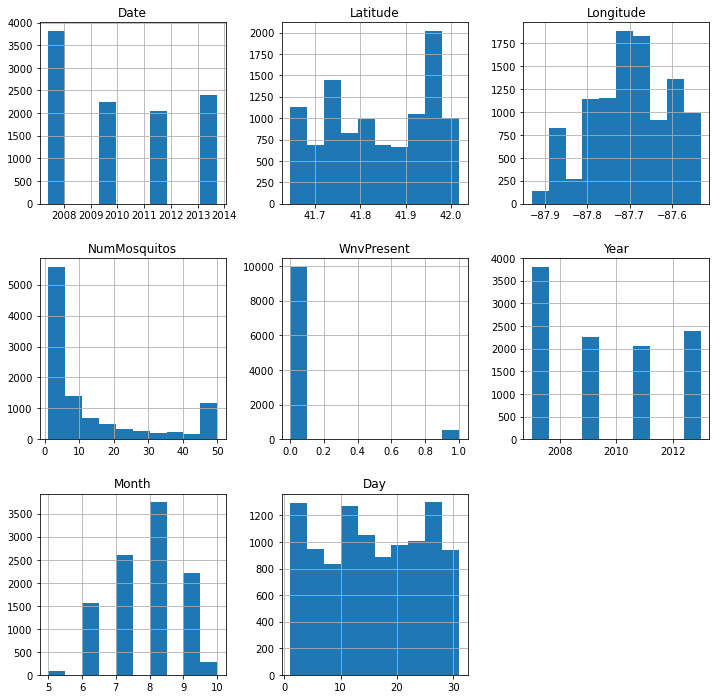

In [48]:
Train.hist(figsize=(12,12))

In [49]:
Train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Latitude,10506.0,41.841139,0.112742,41.644612,41.732984,41.846283,41.954690,42.017430
Longitude,10506.0,-87.699908,0.096514,-87.930995,-87.760070,-87.694991,-87.627796,-87.531635
NumMosquitos,10506.0,12.853512,16.133816,1.000000,2.000000,5.000000,17.000000,50.000000
WnvPresent,10506.0,0.052446,0.222936,0.000000,0.000000,0.000000,0.000000,1.000000
Year,10506.0,2009.576242,2.354645,2007.000000,2007.000000,2009.000000,2011.000000,2013.000000
Month,10506.0,7.692557,1.067675,5.000000,7.000000,8.000000,8.000000,10.000000
Day,10506.0,15.341424,8.901205,1.000000,7.000000,15.000000,24.000000,31.000000


<h2>Test Data Set<h2>

In [50]:
Test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [51]:
Test.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'],axis=1,inplace=True)

In [52]:
Dconverter(Test)

,Id,Date,Species,Trap,Latitude,Longitude,Year,Month,Day
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,2008,6,11
1,2,2008-06-11,CULEX RESTUANS,T002,41.954690,-87.800991,2008,6,11
2,3,2008-06-11,CULEX PIPIENS,T002,41.954690,-87.800991,2008,6,11
3,4,2008-06-11,CULEX SALINARIUS,T002,41.954690,-87.800991,2008,6,11
4,5,2008-06-11,CULEX TERRITANS,T002,41.954690,-87.800991,2008,6,11
...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,T054C,41.925652,-87.633590,2014,10,2
116289,116290,2014-10-02,CULEX TERRITANS,T054C,41.925652,-87.633590,2014,10,2
116290,116291,2014-10-02,CULEX TARSALIS,T054C,41.925652,-87.633590,2014,10,2
116291,116292,2014-10-02,UNSPECIFIED CULEX,T054C,41.925652,-87.633590,2014,10,2


<h2> Combine Train and Test Data Sets with Weather<h2>

In [53]:
Train_merged=Train.merge(Weather_m1,on='Date')
Train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            10506 non-null  datetime64[ns]
 1   Species         10506 non-null  object        
 2   Trap            10506 non-null  object        
 3   Latitude        10506 non-null  float64       
 4   Longitude       10506 non-null  float64       
 5   NumMosquitos    10506 non-null  int64         
 6   WnvPresent      10506 non-null  int64         
 7   Year            10506 non-null  int64         
 8   Month           10506 non-null  int64         
 9   Day             10506 non-null  int64         
 10  Tmax_s1         10506 non-null  int64         
 11  Tmin_s1         10506 non-null  int64         
 12  Tavg_s1         10506 non-null  int64         
 13  Depart_s1       10506 non-null  int64         
 14  DewPoint_s1     10506 non-null  int64         
 15  We

In [55]:
Train_merged.drop(['Year_s2','Month_s2','Day_s2'],axis=1,inplace=True)

In [56]:
Test_merged=Test.merge(Weather_m1,on='Date')
Test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Id              116293 non-null  int64         
 1   Date            116293 non-null  datetime64[ns]
 2   Species         116293 non-null  object        
 3   Trap            116293 non-null  object        
 4   Latitude        116293 non-null  float64       
 5   Longitude       116293 non-null  float64       
 6   Year            116293 non-null  int64         
 7   Month           116293 non-null  int64         
 8   Day             116293 non-null  int64         
 9   Tmax_s1         116293 non-null  int64         
 10  Tmin_s1         116293 non-null  int64         
 11  Tavg_s1         116293 non-null  int64         
 12  Depart_s1       116293 non-null  int64         
 13  DewPoint_s1     116293 non-null  int64         
 14  WetBulb_s1      116293 non-null  int

In [58]:
Test_merged.drop(['Year_s2','Month_s2','Day_s2'],axis=1,inplace=True)

# EDA

<h3>Let's check to see if there is any meaningful correlation between presence of vieus and other parameters<h3><br>
For this aim, I will get the info of the locations with highest amount of infection report, and will try to check the correlation between "behaviour of visrus distribution" and "behaviour of distribution" for every single feature

Text(0.5, 1.0, 'Test Data Set')

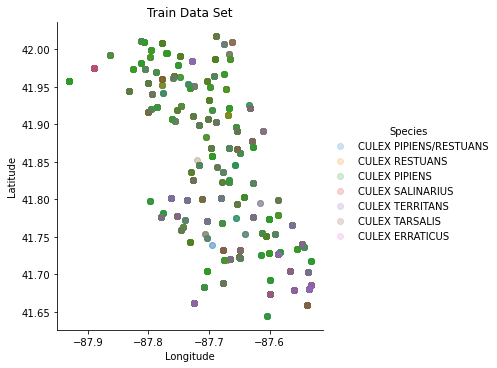

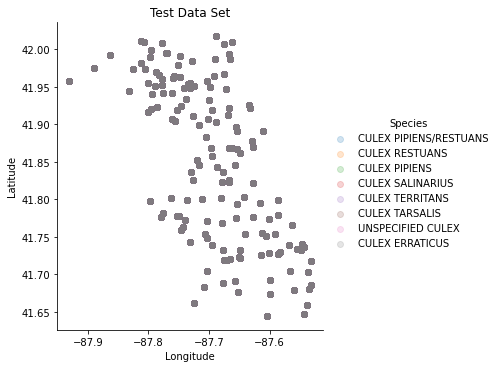

In [59]:
#Distribution of Species within the city for both Train and Test datasets
sns.lmplot(y='Latitude', x='Longitude', hue='Species', 
           data=Train_merged, 
           fit_reg=False, scatter_kws={'alpha':.2})
plt.title("Train Data Set")
sns.lmplot(y='Latitude', x='Longitude', hue='Species', 
           data=Test_merged, 
           fit_reg=False, scatter_kws={'alpha':.2})
plt.title("Test Data Set")

Prettt much the same pattern (visually)!
Now let's chack the species:

Text(0.5, 1.0, 'Test data set')

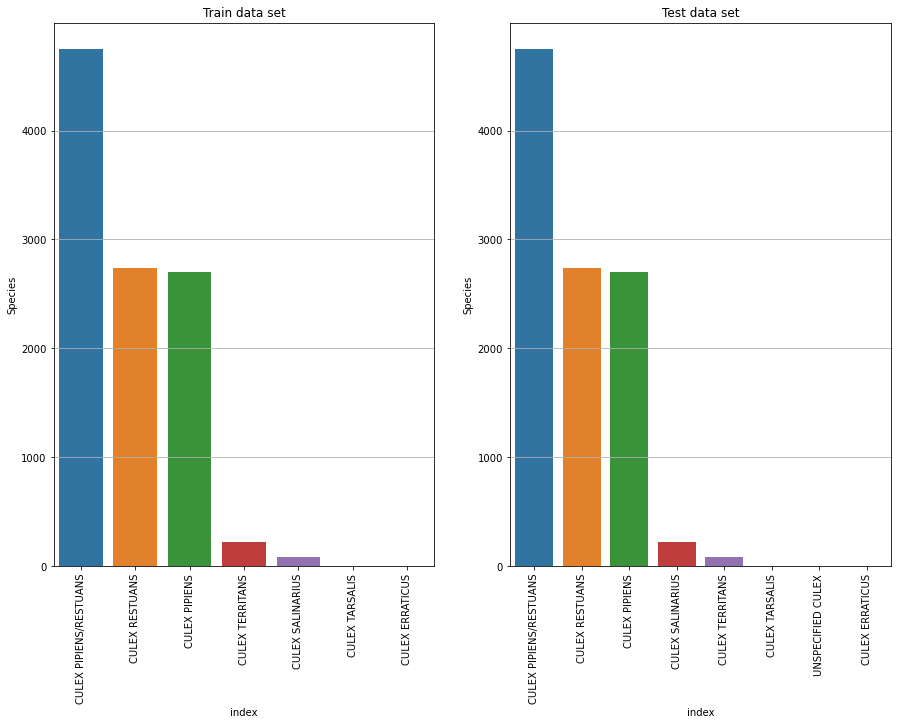

In [69]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
sns.barplot(ax=ax[0],x=Train_merged.Species.value_counts().reset_index()['index'],y=Train.Species.value_counts().reset_index().Species)
sns.barplot(ax=ax[1],x=Test_merged.Species.value_counts().reset_index()['index'],y=Train.Species.value_counts().reset_index().Species)
ax[0].set_xticklabels(Train.Species.value_counts().reset_index()['index'], rotation=90)
ax[1].set_xticklabels(Test_merged.Species.value_counts().reset_index()['index'], rotation=90)
ax[0].set_title('Train data set')
ax[1].set_title('Test data set')

<br>I beleive it's better to change the names and have 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS' and 'CULEX PIPIENS' under one title: 'CULEX PIPIENS/RESTUANS'

In [71]:
Train_merged["Species"].replace({'CULEX RESTUANS':'CULEX PIPIENS/RESTUANS','CULEX PIPIENS':'CULEX PIPIENS/RESTUANS'},inplace=True)
Train_merged.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX SALINARIUS', 'CULEX TERRITANS',
       'CULEX TARSALIS', 'CULEX ERRATICUS'], dtype=object)

In [72]:
Test_merged["Species"].replace({'CULEX RESTUANS':'CULEX PIPIENS/RESTUANS','CULEX PIPIENS':'CULEX PIPIENS/RESTUANS'},inplace=True)
Test_merged.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX SALINARIUS', 'CULEX TERRITANS',
       'CULEX TARSALIS', 'UNSPECIFIED CULEX', 'CULEX ERRATICUS'],
      dtype=object)

In [73]:
Test_merged["Species"].value_counts()

CULEX PIPIENS/RESTUANS    44550
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
UNSPECIFIED CULEX         14345
CULEX ERRATICUS           14345
Name: Species, dtype: int64

In [74]:
Train_merged["Species"].value_counts()

CULEX PIPIENS/RESTUANS    10191
CULEX TERRITANS             222
CULEX SALINARIUS             86
CULEX TARSALIS                6
CULEX ERRATICUS               1
Name: Species, dtype: int64

Add a column to dataset and include a tuple of location info (Longitude and Latitude)

In [174]:
Train_merged['location']=list(zip(Train_merged['Longitude'],Train_merged['Latitude']))

In [177]:
Test_merged['location']=list(zip(Test_merged['Longitude'],Test_merged['Latitude']))

<b>Extract the location of the traps which contained the infected insects (positive_traps)<b>

In [217]:
positive_traps=Train_merged[Train_merged['WnvPresent']==1]
agg_positive_traps=positive_traps.groupby('location').count().reset_index()
#positive_traps.count()

In [184]:
positive_traps.head(3)

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Day,...,DewPoint_s2,WetBulb_s2,Heat_s2,Cool_s2,PrecipTotal_s2,StnPressure_s2,ResultSpeed_s2,ResultDir_s2,AvgSpeed_s2,location
553,2007-07-18,CULEX PIPIENS/RESTUANS,T215,41.686398,-87.531635,50,1,2007,7,18,...,69,71,0,12,0.92,29.18,10.3,24,10.6,"(-87.531635, 41.686398)"
603,2007-07-25,CULEX PIPIENS/RESTUANS,T115,41.673408,-87.599862,50,1,2007,7,25,...,60,66,0,12,0.00,29.35,6.4,23,7.0,"(-87.599862, 41.673408)"
611,2007-07-25,CULEX PIPIENS/RESTUANS,T115,41.673408,-87.599862,50,1,2007,7,25,...,60,66,0,12,0.00,29.35,6.4,23,7.0,"(-87.599862, 41.673408)"


In [189]:
positive_traps['Species'].unique()

array(['CULEX PIPIENS/RESTUANS'], dtype=object)

<h4 style="color:red;">It seems that the CULEX PIPIENS/RESTUANS is the only category which was carrying the virus<h4>

In [221]:
agg_positive_mosq=positive_traps.groupby('NumMosquitos').count().reset_index()
agg_positive_mosq.head(3)

,NumMosquitos,Date,Species,Trap,Latitude,Longitude,WnvPresent,Year,Month,Day,...,DewPoint_s2,WetBulb_s2,Heat_s2,Cool_s2,PrecipTotal_s2,StnPressure_s2,ResultSpeed_s2,ResultDir_s2,AvgSpeed_s2,location
0,1,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
1,2,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
2,3,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15


Plot the location vs number of times that infection has been reported on each location

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


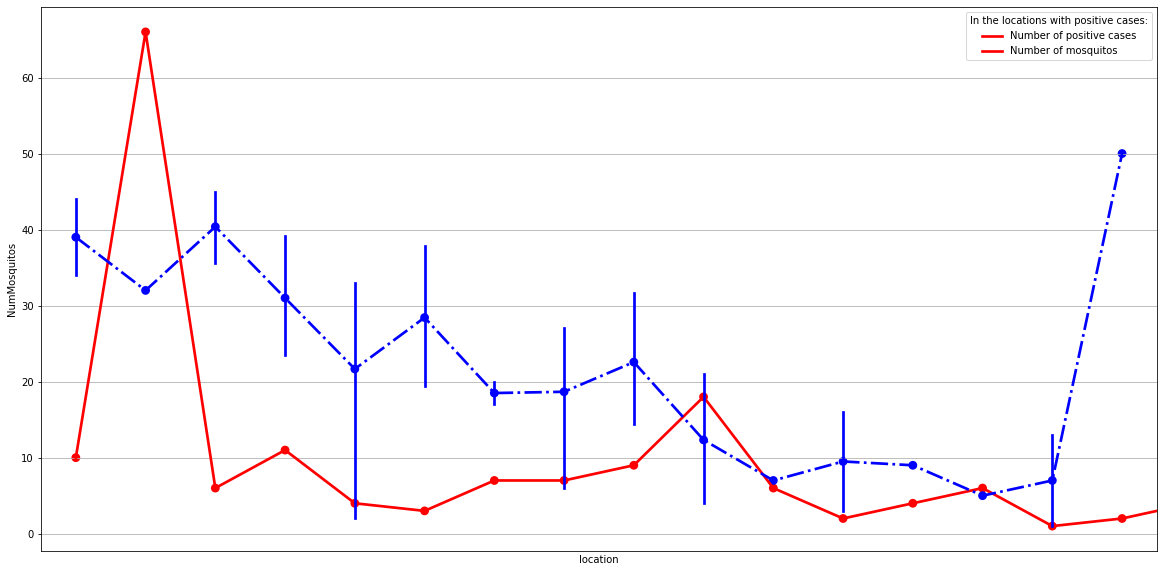

In [232]:
fig,ax = plt.subplots(figsize=(20,10))
sns.pointplot(x='location',y='Trap',data=agg_positive_traps,color='red',label='Number of positive cases')
sns.pointplot(agg_positive_mosq['location'],agg_positive_mosq['NumMosquitos'],color='blue', label='Number of mosquitos',linestyles = '-.')
#ax.set_xticklabels(agg_positive_traps['location'],rotation=90)
plt.legend(title='In the locations with positive cases:', loc='upper right', labels=['Number of positive cases','Number of mosquitos'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

<p>I am not able to deduce any meaningful pattern in the Number of Traps Feature that relates to the presence of Wnv carrying mosquitos<br> <p style="color:red;"> It means, if there are more traps on a location, therse no guarantee that there would be more positive cases reports there

<h3>Effect of Temperature:<h3>

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaq

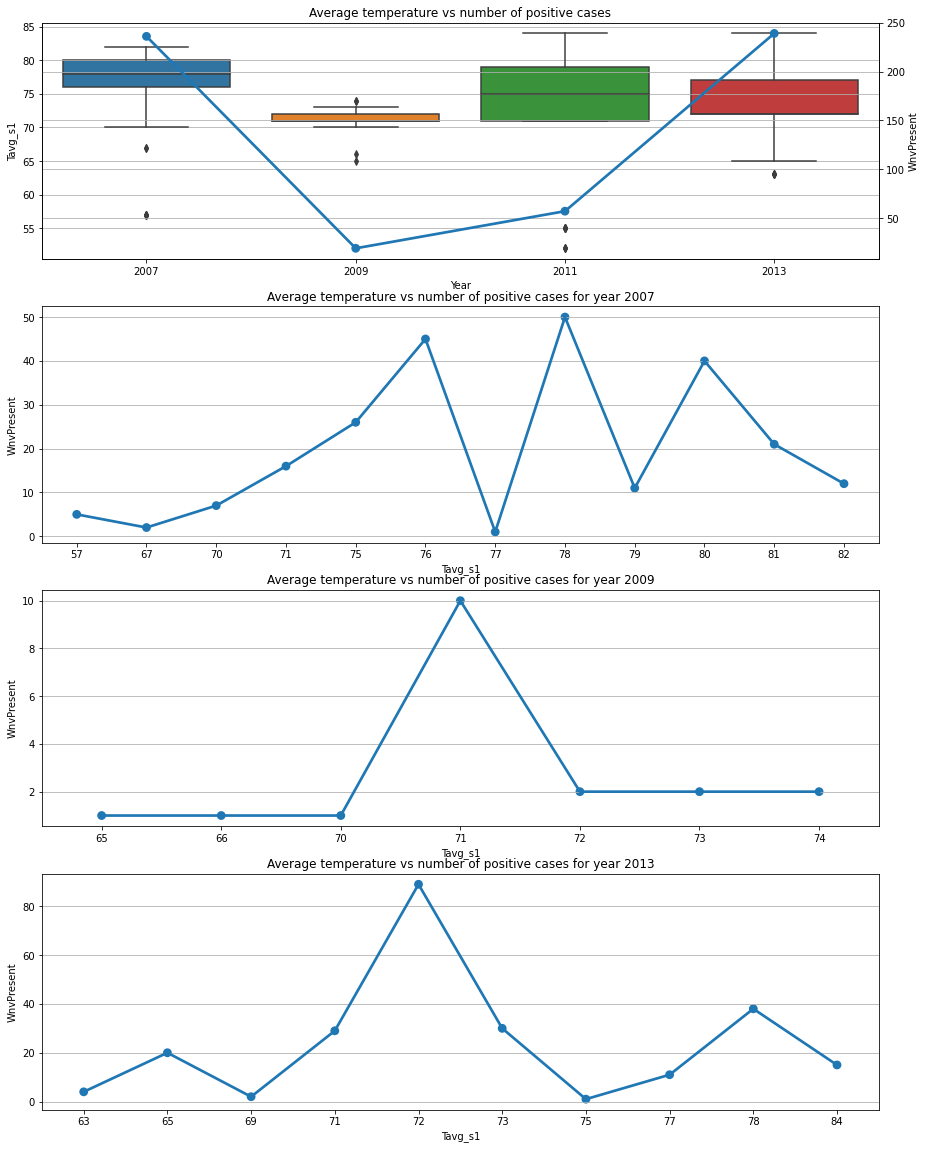

In [261]:
fig, ax = plt.subplots(4,1, figsize=(15,20))
ax1=ax[0]
ax2 = ax1.twinx()
temp=positive_traps.groupby('Year').count().reset_index()
sns.boxplot(positive_traps['Year'],positive_traps['Tavg_s1'], ax=ax1)
sns.pointplot(temp.Year,temp.WnvPresent,ax=ax2)
ax1.set_title('Average temperature vs number of positive cases')
temp1=positive_traps[positive_traps['Year']==2007].groupby(['Tavg_s1']).count().reset_index()
ax3=ax[1]
sns.pointplot(temp1.Tavg_s1,temp1.WnvPresent,ax=ax3)
ax3.set_title('Average temperature vs number of positive cases for year 2007')
ax4=ax[2]
temp2=positive_traps[positive_traps['Year']==2009].groupby(['Tavg_s1']).count().reset_index()
sns.pointplot(temp2.Tavg_s1,temp2.WnvPresent,ax=ax4)
ax4.set_title('Average temperature vs number of positive cases for year 2009')
ax5=ax[3]
temp3=positive_traps[positive_traps['Year']==2013].groupby(['Tavg_s1']).count().reset_index()
sns.pointplot(temp3.Tavg_s1,temp3.WnvPresent,ax=ax5)
ax5.set_title('Average temperature vs number of positive cases for year 2013')
plt.show()

It can be interpreted that verally, higher temperature helps the virus to spread faster, the year 2007 was generally warmer than the other years, and the number of positive infections is higher as well!

<h3>Let's check effect of Moisture in the atmosphere by investigating DewPoint and WetBulb<h3>

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Humidity vs number of positive cases')

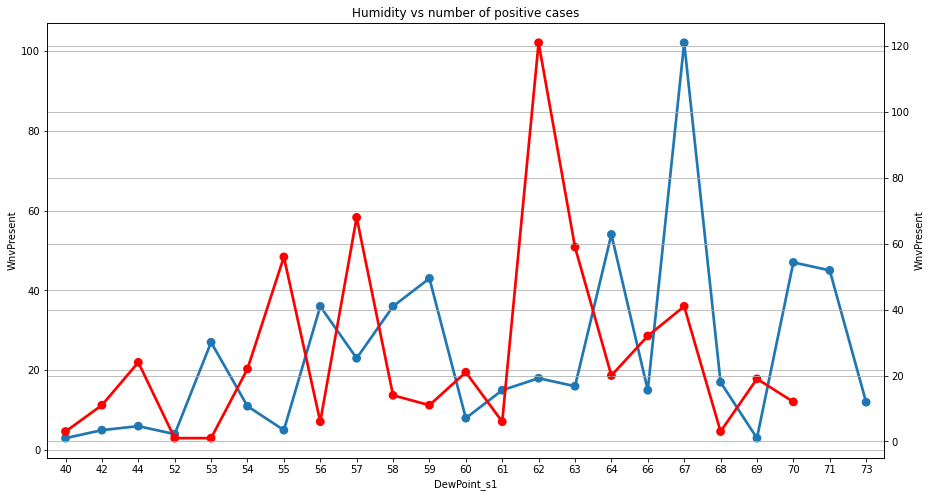

In [361]:
fig, ax = plt.subplots(figsize=(15,8))
ax1 = ax.twinx()
temp=positive_traps.groupby('DewPoint_s1').count().reset_index()
temp1=positive_traps.groupby('WetBulb_s1').count().reset_index()
sns.pointplot(temp1['WetBulb_s1'],temp1['WnvPresent'], ax=ax1,color='red')
sns.pointplot(temp.DewPoint_s1,temp.WnvPresent,ax=ax)
ax1.set_title('Humidity vs number of positive cases')


<h4>It can be interpretted from the plots that higher the humidity, higher the presence of virus!<h4>

<h3>Let's check effect of day length by investigating 'Sunrise_s1', 'Sunset_s1'<h3>

In [341]:
Day_length=[]
for i in range (len(positive_traps.Sunrise_s1)):
    
    Q=positive_traps.reset_index().Sunset_s1[i].astype('str').split()[0][0:2]+str((pd.to_numeric(positive_traps.reset_index().Sunset_s1[i].astype('str').split()[0][2:])/60).astype('str').split()[0][1:])
    T=positive_traps.reset_index().Sunrise_s1[i].astype('str').split()[0][0:1]+str((pd.to_numeric(positive_traps.reset_index().Sunrise_s1[i].astype('str').split()[0][1:])/60).astype('str').split()[0][1:])

    Day_length.append(round(pd.to_numeric(Q)-pd.to_numeric(T),1))
positive_traps['Day_Length']=Day_length
#positive_traps['Day_Length']    

C:\Users\Shaqayeq\AppData\Local\Temp/ipykernel_12744/253112711.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_traps['Day_Length']=Day_length


In [412]:
Day_length1=[]
for i in range (len(Train_merged.Sunrise_s1)):
    
    Q=Train_merged.reset_index().Sunset_s1[i].astype('str').split()[0][0:2]+str((pd.to_numeric(Train_merged.reset_index().Sunset_s1[i].astype('str').split()[0][2:])/60).astype('str').split()[0][1:])
    T=Train_merged.reset_index().Sunrise_s1[i].astype('str').split()[0][0:1]+str((pd.to_numeric(Train_merged.reset_index().Sunrise_s1[i].astype('str').split()[0][1:])/60).astype('str').split()[0][1:])

    Day_length1.append(round(pd.to_numeric(Q)-pd.to_numeric(T),1))
Train_merged['Day_Length']=Day_length1

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Correlation between day length and presence of infection')

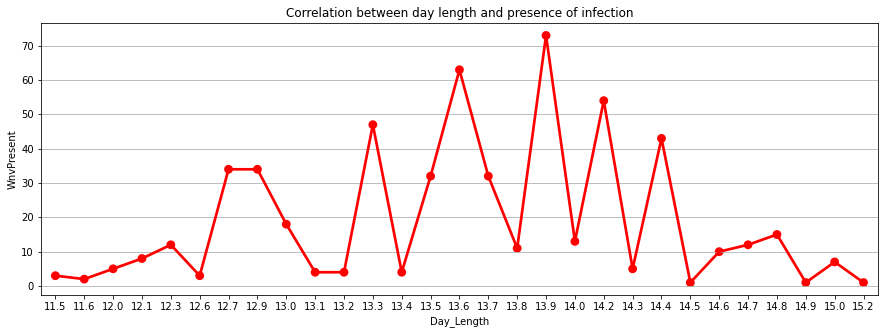

In [347]:
fig, ax = plt.subplots(figsize=(15,5))
temp=positive_traps.groupby('Day_Length').count().reset_index()
sns.pointplot(temp['Day_Length'],temp['WnvPresent'],color='red')
ax.set_title('Correlation between day length and presence of infection')

<h3>It seems that in the long days (such as in summer) and short days (i.e. winter), the presence of infection is less feasible that other seasons

In [359]:
#Other features:
Train_merged['Depth_s1'].value_counts()
#This columns has all zero and will not be considered in futher calculations

0    10506
Name: Depth_s1, dtype: int64

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'PrecipTotal vs number of positive cases')

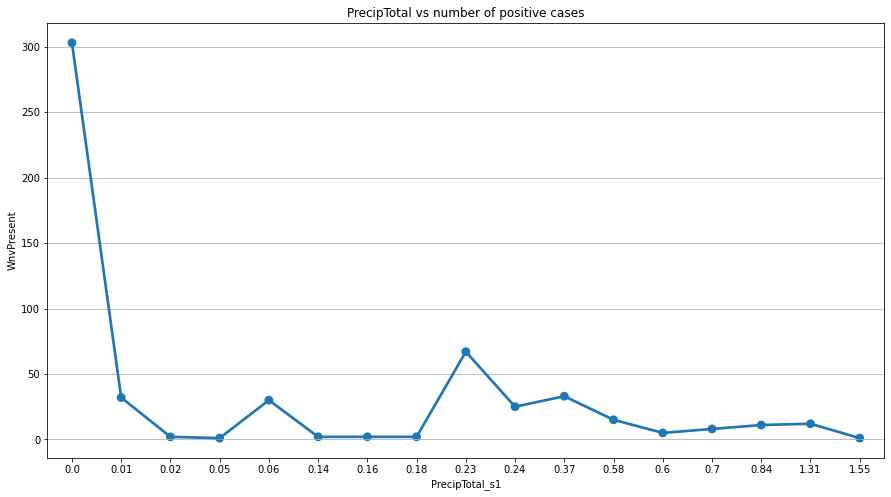

In [364]:
fig, ax = plt.subplots(figsize=(15,8))
temp=positive_traps.groupby('PrecipTotal_s1').count().reset_index()
sns.pointplot(temp.PrecipTotal_s1,temp.WnvPresent,ax=ax)
ax.set_title('PrecipTotal vs number of positive cases')

<h3>When it is zero, the chance of infection is so high!

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


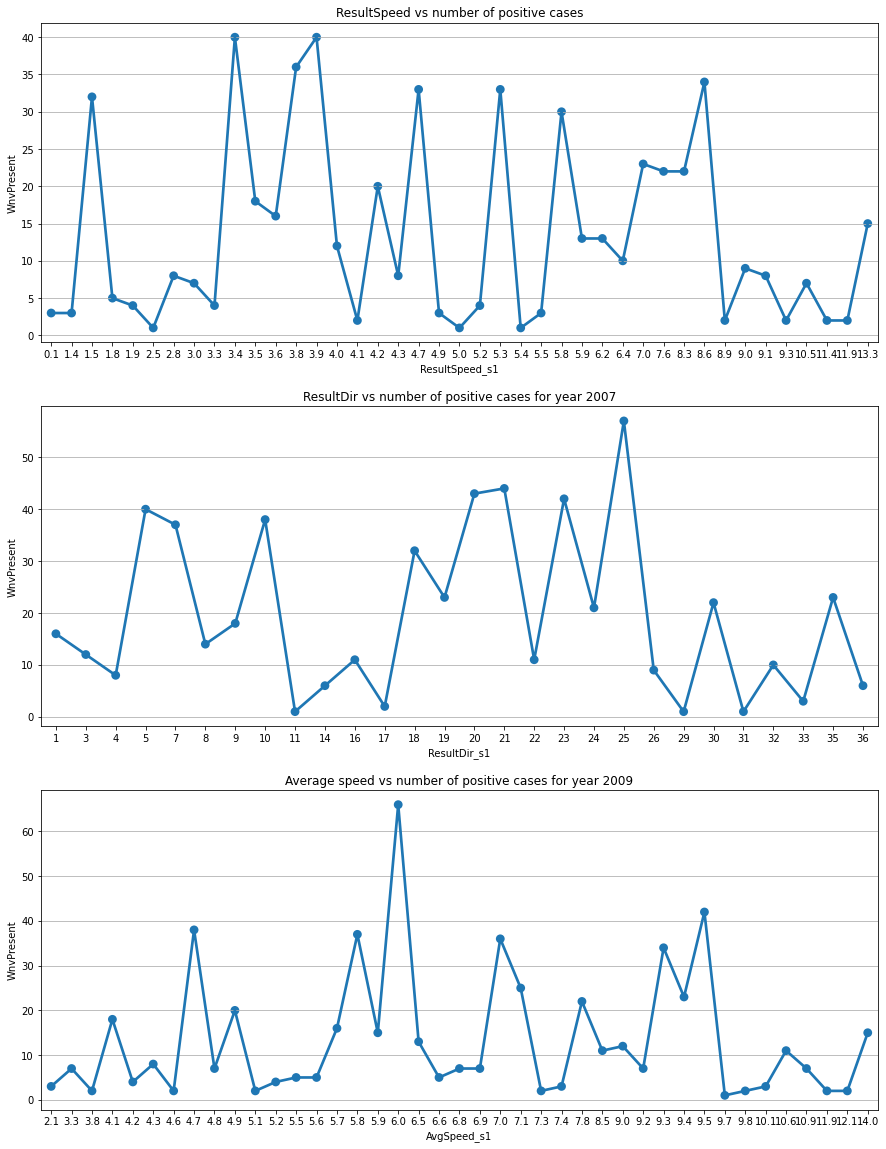

In [379]:
# Effect of wind speed and direction, and station pressure:
fig, ax = plt.subplots(3,1, figsize=(15,20))
ax1=ax[0]
temp=positive_traps.groupby('ResultSpeed_s1').count().reset_index()
sns.pointplot(temp['ResultSpeed_s1'],temp.WnvPresent, ax=ax1)

ax1.set_title('ResultSpeed vs number of positive cases')
temp1=positive_traps.groupby('ResultDir_s1').count().reset_index()
ax3=ax[1]
sns.pointplot(temp1.ResultDir_s1,temp1.WnvPresent,ax=ax3)
ax3.set_title('ResultDir vs number of positive cases for year 2007')
ax4=ax[2]
temp2=positive_traps.groupby(['AvgSpeed_s1']).count().reset_index()
sns.pointplot(temp2.AvgSpeed_s1,temp2.WnvPresent,ax=ax4)
ax4.set_title('Average speed vs number of positive cases for year 2009')
plt.show()


The Average speed has some correlation with presence of infection

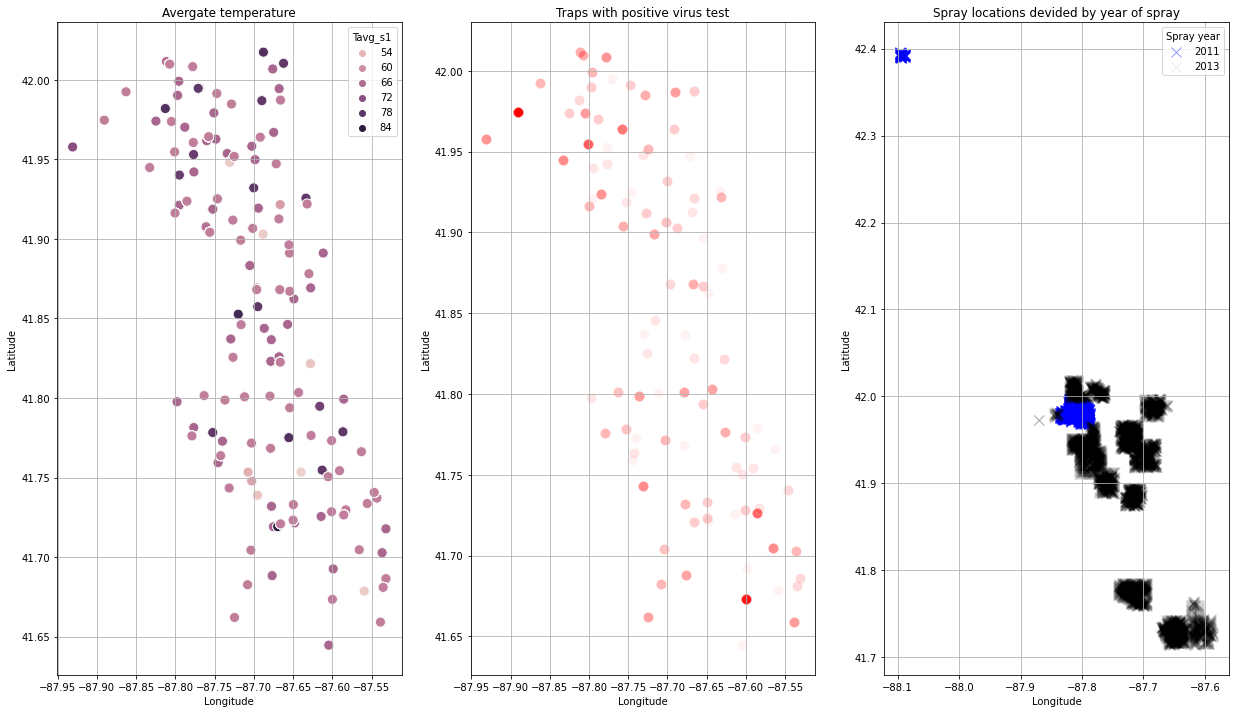

In [380]:
# Let's check the Traps with positive virus test with location of Spray
fig, ax = plt.subplots(1,3, figsize=(21,12))
sns.scatterplot(x='Longitude',y='Latitude',data=Train_merged,ax=ax[0],hue='Tavg_s1',c=['purple'],s=100)
ax[0].set_title('Avergate temperature')
sns.scatterplot(x='Longitude',y='Latitude',data=positive_traps,ax=ax[1],c=['red'], alpha=0.05,s=100)
ax[1].set_title('Traps with positive virus test')
sns.scatterplot(x='Longitude',y='Latitude',data=Spray[Spray['Year']==2011],ax=ax[2],c=['blue'], marker='x', alpha=0.5,legend=2011,s=100)
sns.scatterplot(x='Longitude',y='Latitude',data=Spray[Spray['Year']==2013],ax=ax[2],c=['black'], marker='x', alpha=0.1,legend=2013,s=100)
ax[2].set_title('Spray locations devided by year of spray')
ax[2].legend(title='Spray year', loc='upper right', labels=[2011,2013])
#sns.plot(x='location',y=)

So far, the features: 'location', 'AvgSpeed_s1', DewPoint_s1, WetBulb_s1, NumMosquitos, Tavg_s1, Day_Length, 'PrecipTotal_s1' have shown to have influence on spread of infection


In [554]:
Useful=['Species','location','Latitude','Longitude','WnvPresent', 'AvgSpeed_s1', 'DewPoint_s1', 'WetBulb_s1', 'NumMosquitos', 'Tavg_s1', 'PrecipTotal_s1','Day_Length','AvgSpeed_s2', 'DewPoint_s2', 'WetBulb_s2', 'Tavg_s2', 'PrecipTotal_s2']
ddf=Train_merged[Useful]

# Incorporate test data to have same columns as the train dataset

In [555]:
df=pd.get_dummies(ddf,columns=['Species'])

# Modeling

In [556]:
df.columns

Index(['location', 'Latitude', 'Longitude', 'WnvPresent', 'AvgSpeed_s1',
       'DewPoint_s1', 'WetBulb_s1', 'NumMosquitos', 'Tavg_s1',
       'PrecipTotal_s1', 'Day_Length', 'AvgSpeed_s2', 'DewPoint_s2',
       'WetBulb_s2', 'Tavg_s2', 'PrecipTotal_s2', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'],
      dtype='object')

In [557]:
df['Species_CULEX ERRATICUS']=df['Species_CULEX ERRATICUS'].astype('int')
df['Species_CULEX PIPIENS/RESTUANS']=df['Species_CULEX PIPIENS/RESTUANS'].astype('int')
df['Species_CULEX SALINARIUS']=df['Species_CULEX SALINARIUS'].astype('int')
df['Species_CULEX TARSALIS']=df['Species_CULEX TARSALIS'].astype('int')
df['Species_CULEX TERRITANS']=df['Species_CULEX TERRITANS'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   location                        10506 non-null  object 
 1   Latitude                        10506 non-null  float64
 2   Longitude                       10506 non-null  float64
 3   WnvPresent                      10506 non-null  int64  
 4   AvgSpeed_s1                     10506 non-null  float64
 5   DewPoint_s1                     10506 non-null  int64  
 6   WetBulb_s1                      10506 non-null  int64  
 7   NumMosquitos                    10506 non-null  int64  
 8   Tavg_s1                         10506 non-null  int64  
 9   PrecipTotal_s1                  10506 non-null  float64
 10  Day_Length                      10506 non-null  float64
 11  AvgSpeed_s2                     10506 non-null  float64
 12  DewPoint_s2                     

In [558]:
X_cols=['Latitude','Longitude', 'WnvPresent', 'AvgSpeed_s1', 'DewPoint_s1', 'WetBulb_s1',
        'Tavg_s1', 'PrecipTotal_s1', 'Day_Length',
       'AvgSpeed_s2', 'DewPoint_s2', 'WetBulb_s2', 'Tavg_s2',
       'PrecipTotal_s2', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS']
X=df[X_cols]
y=df['WnvPresent']

In [559]:
X.columns

Index(['Latitude', 'Longitude', 'WnvPresent', 'AvgSpeed_s1', 'DewPoint_s1',
       'WetBulb_s1', 'Tavg_s1', 'PrecipTotal_s1', 'Day_Length', 'AvgSpeed_s2',
       'DewPoint_s2', 'WetBulb_s2', 'Tavg_s2', 'PrecipTotal_s2',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS'],
      dtype='object')

In [561]:
y

0        0
1        0
2        0
3        0
4        0
        ..
10501    1
10502    0
10503    0
10504    0
10505    0
Name: WnvPresent, Length: 10506, dtype: int64

<AxesSubplot:>

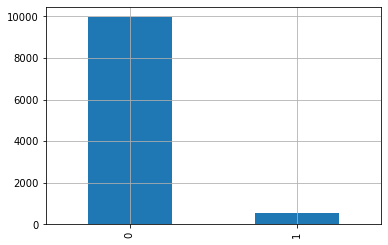

In [544]:
y.value_counts().plot.bar()

In [511]:
y['WnvPresent']=y['WnvPresent'].astype('int')

Imbalanced dataset:
Dealing with imbalance through <b>Under Sampling Method:<b>

In [562]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
print(Counter(y))
# instantiating the random undersampler
rus = RandomUnderSampler() 
# resampling X, y
X_rus, y_rus = rus.fit_resample(X, y)
# new class distribution
print(Counter(y_rus))

Counter({0: 9955, 1: 551})
Counter({0: 551, 1: 551})


In [563]:
X_rus

,Latitude,Longitude,WnvPresent,AvgSpeed_s1,DewPoint_s1,WetBulb_s1,Tavg_s1,PrecipTotal_s1,Day_Length,AvgSpeed_s2,DewPoint_s2,WetBulb_s2,Tavg_s2,PrecipTotal_s2,Species_CULEX ERRATICUS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,41.991429,-87.747113,0,7.2,67,70,77,0.92,15.2,6.8,65,69,79.0,0.59,0,1,0,0,0
1,41.743402,-87.731435,0,4.2,52,56,61,0.00,12.4,5.4,51,57,63.0,0.00,0,1,0,0,0
2,41.921177,-87.795180,0,4.3,60,66,76,0.00,13.0,5.0,59,67,79.0,0.00,0,1,0,0,0
3,41.904194,-87.756155,0,4.2,52,58,63,0.00,12.0,4.6,52,58,65.0,0.00,0,1,0,0,0
4,41.743402,-87.731435,0,14.0,70,75,84,0.58,14.8,13.9,69,75,86.0,0.58,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,41.974689,-87.890615,1,10.6,68,70,77,0.84,12.3,10.0,66,69,77.0,0.84,0,1,0,0,0
1098,41.964242,-87.757639,1,4.2,52,58,63,0.00,12.0,4.6,52,58,65.0,0.00,0,1,0,0,0
1099,41.776156,-87.778927,1,4.2,52,58,63,0.00,12.0,4.6,52,58,65.0,0.00,0,1,0,0,0
1100,41.974689,-87.890615,1,4.2,52,58,63,0.00,12.0,4.6,52,58,65.0,0.00,0,1,0,0,0


In [569]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_rus,
                                                    y_rus,
                                                    test_size=0.2,
                                                    random_state=42)

In [570]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [571]:
lr_model = LogisticRegression()

In [572]:
lr = LogisticRegression(solver="lbfgs",max_iter=100000)
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test, X_test, predicted_lr)
lrg.confusion_matrix ()

True Negatives: 118
False Positives: 0
False Negatives: 0
True Positives: 103
Precision: 1.0
Recall: 1.0
F1 score: 1.0
roc_auc_score: 1.0


In [573]:
cm=confusion_matrix(y_test,predicted_lr)

<AxesSubplot:>

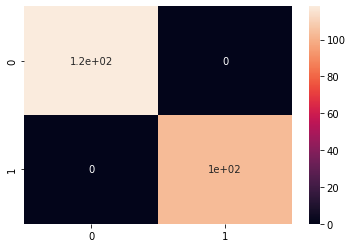

In [575]:
sns.heatmap(cm,annot=True)

<h3> Synthetic Minority Oversampling Technique or SMOTE:

In [577]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_sample(X, y)

C:\Users\Shaqayeq\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WnvPresent', ylabel='count'>

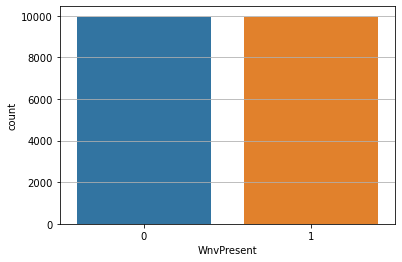

In [579]:
sns.countplot(oversampled_Y)

In [580]:

X_train, X_test, y_train, y_test = train_test_split(oversampled_X, oversampled_Y,
                                                    test_size=0.2,
                                                    random_state=42)

In [581]:
lr = LogisticRegression(solver="lbfgs",max_iter=100000)
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test, X_test, predicted_lr)
lrg.confusion_matrix ()

True Negatives: 2004
False Positives: 0
False Negatives: 0
True Positives: 1978
Precision: 1.0
Recall: 1.0
F1 score: 1.0
roc_auc_score: 1.0


# Model Evaluation

In [576]:
class model_evaluation:
   
    def __init__(self, y_test, X_test, predicted_value):
        self.y_test = y_test
        self.predicted_value = predicted_value
        self.x_test = X_test
        
    def confusion_matrix (self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.predicted_value).ravel()
        print("True Negatives: %s" % tn)
        print("False Positives: %s" % fp)
        print("False Negatives: %s" % fn)
        print("True Positives: %s" % tp)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print("Precision: {}" .format (tp/(tp+fp)))
        print("Recall: {}" .format (tp/(tp+fn)))
        F1_score = 2*((precision*recall)/(precision+recall))
        print ("F1 score: {}" .format(2*((precision*recall)/(precision+recall))))
        probability = lr.predict_proba(X_test)[:,1]
        roc_auc_score_ = roc_auc_score(y_test, probability)
        print ("roc_auc_score: {}"  .format(roc_auc_score_))